# MNIST

A popular dataframe for first steps and experiments in computer vision. So here are my solutions for MNIST using torch.

In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from pathlib import Path
files_path = Path("mnist_files")
files_path.mkdir(exist_ok=True)

## Downloading data

There is a special module in Torch that allows you to download the MNIST dataset to your computer.

In [4]:
data_train = MNIST(
    str(files_path),
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
data_valid = MNIST(
    str(files_path),
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

In [5]:
train_loader = DataLoader(data_train, batch_size = 64, shuffle = True)
valid_loader = DataLoader(data_valid, batch_size = 64, shuffle = True)

## Data description

**Input features** is a matrix describing images with dimensions `(n_channels, picture_width, picture_height)`.

In [6]:
data_train[0][0].shape

torch.Size([1, 28, 28])

**Target** is an integer that indicates which number will be displayed on the image.

In [7]:
data_train[0][1]

5

## Basic network

### Definition and usage

Here is a model that implements a transformation that takes tesnsor describing picture and returns model 10 numbers.

In [8]:
basic_network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

basic_network(data_train[0][0]).tolist()

[[0.007802577689290047,
  -0.026246704161167145,
  -0.0670308992266655,
  -0.010161032900214195,
  -0.017714858055114746,
  -0.19654646515846252,
  0.1459650993347168,
  0.05521680787205696,
  0.03541004657745361,
  0.03896047919988632]]

We understand the intex of the maximum value as the predicted class. To extract it from the model result, you need to use code like in the cell below.

In [9]:
pred_number, pred_class = torch.max(basic_network(data_train[0][0]), 1)
print("predicted number", pred_number.item())
print("predicted class", pred_class.item())

predicted number 0.1459650993347168
predicted class 6


Or the same code applied to the whole batch.

In [10]:
X, y = next(iter(train_loader))
values, classes = torch.max(basic_network(X), 1)

pd.DataFrame({
    "values" : values.tolist(),
    "classes" : classes.tolist()
}).head()

,values,classes
0,0.075086,7
1,0.093597,3
2,0.094069,7
3,0.131403,7
4,0.122878,6


### Optimization

Below is the function that implements the model training epoch.

In [11]:
def epoch(
    model: nn.Module, 
    data_loader: DataLoader, 
    optimizer: optim.Optimizer, 
    loss_fn
):
    model.train()
    loss_values = []
    
    for x, y in tqdm(data_loader, desc = "train"):
        optimizer.zero_grad()
        output = model(x)
        loss_val = loss_fn(output, y)
        loss_values.append(loss_val.item())
        loss_val.backward()
        optimizer.step()

    return sum(loss_values)/len(loss_values)

### Evaluation

Here is a function that allows you to estimate the loss and accuracy of the model for test data.

In [12]:
optimizer = optim.Adam(basic_network.parameters(), lr = 1e-3)
loss_fn = nn.CrossEntropyLoss()

@torch.inference_mode()
def evaluate(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn
    ):
    loss_values = []
    model.eval()

    total = 0
    correct = 0
 
    for x, y in tqdm(data_loader, desc = "evaluation"):
        output = model(x)
        
        loss_val = loss_fn(output, y)
        loss_values.append(loss_val.item())

        _, classes = torch.max(model(x), 1)
        
        total += len(x)
        correct += (classes == y).sum().item()
    
    return sum(loss_values)/len(loss_values), correct/total

### Fitting

Here is a cycle that runs a few epochs of network load.

In [13]:
train_scores, test_scores, accuracies = [], [], []

for i in range(100):
    train_scores.append(epoch(
        model = basic_network,
        data_loader = train_loader,
        optimizer = optimizer,
        loss_fn = loss_fn
    ))
    test_score, accuracy = evaluate(
        model = basic_network, 
        data_loader = valid_loader,
        loss_fn = loss_fn
    )
    test_scores.append(test_score)
    accuracies.append(accuracy)


    clear_output()
    if accuracy > 0.98:
        break

Visualise the progress of the model in the plots below.

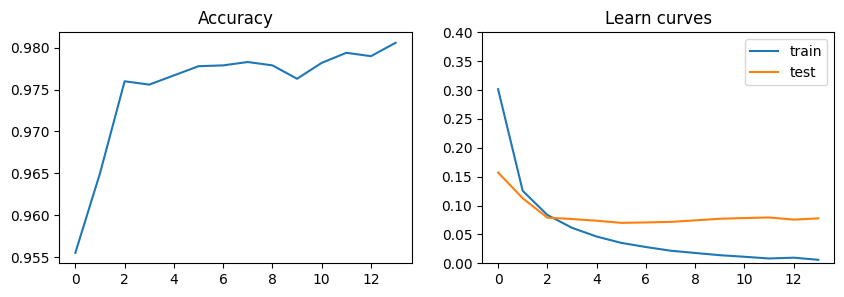

In [14]:
plt.figure(figsize = [10, 3])
plt.subplot(121)
plt.title("Accuracy")
plt.plot(range(len(accuracies)), accuracies)
plt.subplot(122)
plt.title("Learn curves")
plt.plot(range(len(train_scores)), train_scores)
plt.plot(range(len(test_scores)), test_scores)
plt.legend(["train", "test"])
plt.ylim(0,0.4)
plt.show()

## Сonvolutional neural network

You may think that result of the previous model is pretty good, but you can imporove it iven more using convolutinal layers.

In the next cell, we've just defined the model that we're going to fit.

In [17]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size =  2),

    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),

    nn.Flatten(),
    nn.Linear(4*4*64, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

We can use the same methods for fitting as for the basic model.

**Note** Don't forget to pass the weights of the new model to the optimiser, otherwise it will continue to work with the weights of the base model.

In [18]:
optimizer = optim.Adam(cnn.parameters(), lr = 1e-3)

train_scores, test_scores, accuracies = [], [], []

for i in range(100):
    train_scores.append(epoch(
        model = cnn,
        data_loader = train_loader,
        optimizer = optimizer,
        loss_fn = loss_fn
    ))
    test_score, accuracy = evaluate(
        model = cnn, 
        data_loader = valid_loader,
        loss_fn = loss_fn
    )
    test_scores.append(test_score)
    accuracies.append(accuracy)


    clear_output()
    if accuracy > 0.993:
        break

And visualising of the results:

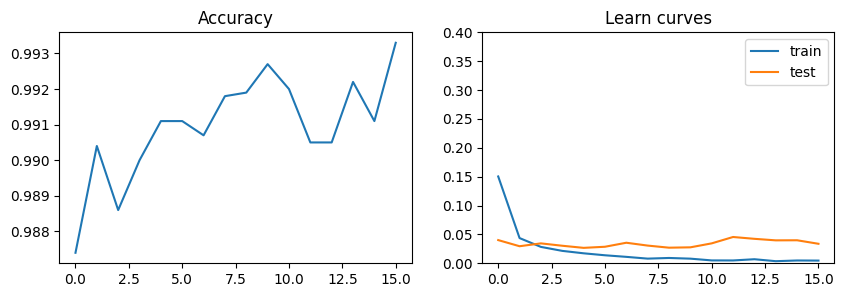

In [19]:
plt.figure(figsize = [10, 3])
plt.subplot(121)
plt.title("Accuracy")
plt.plot(range(len(accuracies)), accuracies)
plt.subplot(122)
plt.title("Learn curves")
plt.plot(range(len(train_scores)), train_scores)
plt.plot(range(len(test_scores)), test_scores)
plt.legend(["train", "test"])
plt.ylim(0,0.4)
plt.show()